# Optimization of TLN using differentiable simulation - with mismatch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_formats = ['svg']
# Library imports
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['figure.dpi'] = 200
import matplotlib.pyplot as plt

from jax import config
config.update("jax_enable_x64", True)
from tqdm.auto import tqdm, trange

import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import diffrax as dr
import sympy as sp

from jax import config; config.update('jax_log_compiles', True); # config.update('jax_platform_name', 'cpu')

print(f"Jax devices: {jax.devices()}")

from typing import Dict

Jax devices: [CpuDevice(id=0)]


In [3]:
# Local imports
from ark.cdg.cdg import CDG, CDGNode
from ark.compiler import ArkCompiler
from ark.rewrite import RewriteGen, SympyRewriteGen
from ark.solver import SMTSolver
from ark.specification.cdg_types import NodeType, EdgeType
from ark.validator import ArkValidator
from spec import pulse_sympy
from tln_example import create_tline_branch, IdealV, IdealI, IdealE

## Generate a TLN graph from specification

--- block colors ---
--- line colors ---


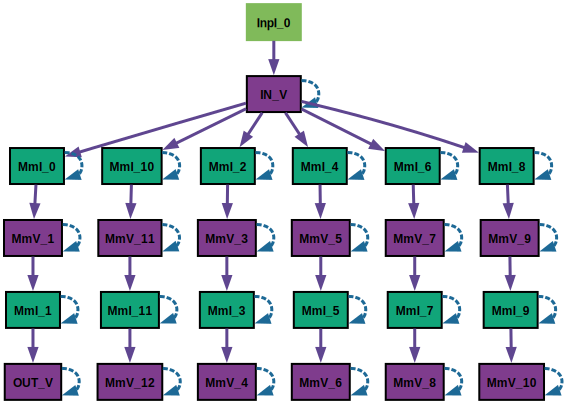

In [4]:
from ark.specification.specification import CDGSpec
from examples.tln.tln_example import make_full_graph


def make_hub_and_spoke(num_spokes: int, spoke_length: int, mismatch=True) -> tuple[CDG, CDGSpec]:
    graph, spec = make_full_graph(mismatch=mismatch, branch_args_override={
        'line_len': spoke_length,
        'branch_stride': spoke_length,
        'branches_per_node': num_spokes,
        'branch_len': spoke_length - 1,
        'branch_offset': 0,
    })
    return graph, spec

# graph, spec = make_hub_and_spoke(num_spokes=2, spoke_length=3, mismatch=True)

branch_args = {
    "line_len": 2,
    "branch_stride": 2,
    "branches_per_node": 5,
    "branch_len": 1,
    "branch_offset": 0,
}
graph, spec = make_full_graph(mismatch=True,
                              branch_args_override=branch_args)


from ark.visualize.graphviz_gen import cdg_to_graphviz_display
cdg_to_graphviz_display(cdg_lang=spec, cdg=graph)

### Add nonlinearities between tline branches

In [5]:
# Modify graph to add nonlinearities between some of the branches
def find_node(name: str):
    return next(node for node in graph.nodes if node.name == name)
print(graph.edges[25].cdg_type)
find_node('MmV_1')

<class 'ark.specification.cdg_types.MmE'>


In [6]:
MmE = spec.edge_types()[0]

In [7]:
add_edges_between = [('MmV_1', 'MmI_11'), ('MmV_11', 'MmI_2'), ('MmV_3', 'MmI_4'), ('MmV_5', 'MmI_7')]

for v_node, i_node in add_edges_between:
    graph.connect(edge=MmE(ws=1.0, wt=1.0), src=find_node(v_node), dst=find_node(i_node))

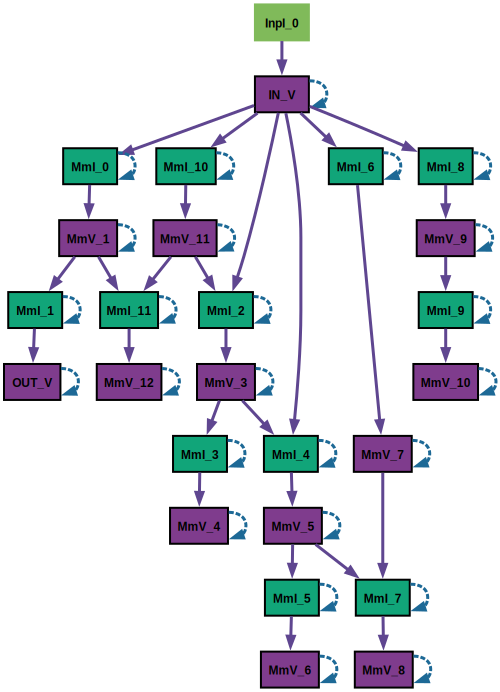

In [8]:
cdg_to_graphviz_display(cdg_lang=spec, cdg=graph)

Now we have a graph with representing the TLN with certain arguments, and can compile it to SymPy expressions.

In [9]:
from ark.simulate.dynamical_system import DynamicalSystem
ds = DynamicalSystem.from_ark(cdg=graph, spec=spec)
ds

/Users/marcel/git/Ark/ark/simulate/dynamical_system.py:110: UserWarning: Replacing InpI_0_fn with default expression
  warn("Replacing InpI_0_fn with default expression")


{t: 0, IN_V: 1, MmI_0: 2, MmI_1: 3, MmI_2: 4, MmI_3: 5, MmI_4: 6, MmI_5: 7, MmI_6: 8, MmI_7: 9, MmI_8: 10, MmI_9: 11, MmI_10: 12, MmI_11: 13, MmV_1: 14, MmV_3: 15, MmV_4: 16, MmV_5: 17, MmV_6: 18, MmV_7: 19, MmV_8: 20, MmV_9: 21, MmV_10: 22, MmV_11: 23, MmV_12: 24, OUT_V: 25, IN_V_c: 26, IN_V_g: 27, InpI_0_g: 28, MmE_0_ws: 29, MmE_0_wt: 30, MmE_1_ws: 31, MmE_1_wt: 32, MmE_2_ws: 33, MmE_2_wt: 34, MmE_3_ws: 35, MmE_3_wt: 36, MmE_4_ws: 37, MmE_4_wt: 38, MmE_5_ws: 39, MmE_5_wt: 40, MmE_6_ws: 41, MmE_6_wt: 42, MmE_7_ws: 43, MmE_7_wt: 44, MmE_8_ws: 45, MmE_8_wt: 46, MmE_9_ws: 47, MmE_9_wt: 48, MmE_10_ws: 49, MmE_10_wt: 50, MmE_11_ws: 51, MmE_11_wt: 52, MmE_12_ws: 53, MmE_12_wt: 54, MmE_13_ws: 55, MmE_13_wt: 56, MmE_14_ws: 57, MmE_14_wt: 58, MmE_15_ws: 59, MmE_15_wt: 60, MmE_16_ws: 61, MmE_16_wt: 62, MmE_17_ws: 63, MmE_17_wt: 64, MmE_18_ws: 65, MmE_18_wt: 66, MmE_20_ws: 67, MmE_20_wt: 68, MmE_22_ws: 69, MmE_22_wt: 70, MmE_24_ws: 71, MmE_24_wt: 72, MmE_26_ws: 73, MmE_26_wt: 74, MmE_28_ws: 75, 

In [14]:
ds.symbol_types

{t: Time(),
 IN_V: Transient(name='IN_V', unit=<Unit('volt')>, noise=NoiseDescription()),
 MmI_0: Transient(name='MmI_0', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_1: Transient(name='MmI_1', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_2: Transient(name='MmI_2', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_3: Transient(name='MmI_3', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_4: Transient(name='MmI_4', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_5: Transient(name='MmI_5', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_6: Transient(name='MmI_6', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_7: Transient(name='MmI_7', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_8: Transient(name='MmI_8', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_9: Transient(name='MmI_9', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_10: Transient(name='MmI_10', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_1

### Add non-linearities to each equation

In [15]:
# Find the added branches and wrap the equations in a tanh
non_linear_scale = 5e-8
non_linearity = lambda x: x

def pre_transform(expr: sp.Expr):
    match expr:
        case sp.Mul(args=(*_, sp.Pow(args=(_, -1)))):
            print(f'Found mul! {expr}')
            return non_linearity(expr)
        case sp.Symbol() | sp.Number() | sp.Integer() | sp.Tuple():
            return expr
    new_args = [
        pre_transform(arg)
        for arg in expr.args
    ]
    new_expr = expr.func(*new_args)
    return new_expr


In [16]:
# Wrap all multiply and divides in a non-linear function
non_linear_scale = 2e-8
scaled_tanh = lambda x: sp.tanh(non_linear_scale * x) / non_linear_scale
def chua_nonlinearity(x):
    return sp.Piecewise(
        (x, sp.Abs(x) < 0.1),
        (x * 0.5 + 0.5, True)
    )
nonlinearity = scaled_tanh
def pre_transform_with(expr: sp.Expr, with_variable_containing: str):
    match expr:
        case sp.Mul(args=(*_, sp.Pow(args=(_, -1)))):
            if with_variable_containing in map(str, expr.free_symbols):
                print(f'Found mul with {with_variable_containing} in {expr}')
                return nonlinearity(expr)
            return expr
        case sp.Symbol() | sp.Number() | sp.Integer() | sp.Tuple():
            return expr
    new_args = [
        pre_transform_with(arg, with_variable_containing=with_variable_containing)
        for arg in expr.args
    ]
    new_expr = expr.func(*new_args)
    return new_expr
def add_nonlinearity_to_eq(eq: sp.Eq):
    lhs_symbol = list(eq.lhs.free_symbols)[0]
    for first, second in add_edges_between:
        if first == lhs_symbol.name:
            print(f'Found first! {eq}')
            return pre_transform_with(eq, with_variable_containing=second)
        elif second == lhs_symbol.name:
            print(f'Found second! {eq}')
            return pre_transform_with(eq, with_variable_containing=first)
    return eq
# for eq in sympy_eqs_expanded:
#     add_nonlinearity_to_eq(eq)
# pre_transform_with(sympy_eqs_expanded[1])
# sympy_eqs_with_nonlinearity = [add_nonlinearity_to_eq(eq) for eq in sympy_eqs_expanded]
# for eq in sympy_eqs_with_nonlinearity:
#    display(eq)

# Hmm, that works, but maybe it's better to wrap the whole expression in a tanh instead

In [17]:
# def rhs_non_linearity(eq: sp.Eq):
#     assert isinstance(eq, sp.Eq)
#     return sp.Eq(eq.lhs, non_linearity(eq.rhs))
# 
# sympy_eqs_complete = [rhs_non_linearity(eq) if i != 0 else eq for i, eq in enumerate(sympy_eqs_expanded)]
# sympy_eqs_complete = sympy_eqs_with_nonlinearity
# sympy_eqs_complete = sympy_eqs_expanded
# sympy_eqs_complete

In [18]:
# Now we gather the parameters necessary from the respective nodes in the graph
all_param_vars = ds.parameter_symbols().keys()
def get_param_from_dict(param_name: str) -> float:
    element_name = '_'.join(param_name.split('_')[:-1])
    param_name = param_name.split('_')[-1]
    return graph_param_dict[element_name][param_name]

# Collect all node parameters into a dictionary with dictionary values
node_param_dict = {node.name: node.attrs for node in graph.nodes}
edge_param_dict = {edge.name: edge.attrs for edge in graph.edges}
graph_param_dict = node_param_dict | edge_param_dict

# Gather all necessary parameters in a flat dictionary
param_dict = {k: get_param_from_dict(k.name) for k in all_param_vars}
param_dict[sp.symbols('OUT_V_g')] = 0.0
param_dict

{IN_V_c: 1e-09,
 IN_V_g: 0.0,
 InpI_0_g: 1.0,
 MmE_0_ws: 1.0,
 MmE_0_wt: 1.0,
 MmE_1_ws: 1.0,
 MmE_1_wt: 1.0,
 MmE_2_ws: 1.0,
 MmE_2_wt: 1.0,
 MmE_3_ws: 1.0,
 MmE_3_wt: 1.0,
 MmE_4_ws: 1.0,
 MmE_4_wt: 1.0,
 MmE_5_ws: 1.0,
 MmE_5_wt: 1.0,
 MmE_6_ws: 1.0,
 MmE_6_wt: 1.0,
 MmE_7_ws: 1.0,
 MmE_7_wt: 1.0,
 MmE_8_ws: 1.0,
 MmE_8_wt: 1.0,
 MmE_9_ws: 1.0,
 MmE_9_wt: 1.0,
 MmE_10_ws: 1.0,
 MmE_10_wt: 1.0,
 MmE_11_ws: 1.0,
 MmE_11_wt: 1.0,
 MmE_12_ws: 1.0,
 MmE_12_wt: 1.0,
 MmE_13_ws: 1.0,
 MmE_13_wt: 1.0,
 MmE_14_ws: 1.0,
 MmE_14_wt: 1.0,
 MmE_15_ws: 1.0,
 MmE_15_wt: 1.0,
 MmE_16_ws: 1.0,
 MmE_16_wt: 1.0,
 MmE_17_ws: 1.0,
 MmE_17_wt: 1.0,
 MmE_18_ws: 1.0,
 MmE_18_wt: 1.0,
 MmE_20_ws: 1.0,
 MmE_20_wt: 1.0,
 MmE_22_ws: 1.0,
 MmE_22_wt: 1.0,
 MmE_24_ws: 1.0,
 MmE_24_wt: 1.0,
 MmE_26_ws: 1.0,
 MmE_26_wt: 1.0,
 MmE_28_ws: 1.0,
 MmE_28_wt: 1.0,
 MmE_29_wt: 1.0,
 MmE_30_ws: 1.0,
 MmE_30_wt: 1.0,
 MmE_31_ws: 1.0,
 MmE_31_wt: 1.0,
 MmE_32_ws: 1.0,
 MmE_32_wt: 1.0,
 MmE_33_ws: 1.0,
 MmE_33_wt: 1.0,
 MmI_

In [19]:
# Gather initial values for the LHS variables
# TODO(marcelroed): Currently all at zero -- should this change?
print(ds.symbol_types)
lhs_vars = ds.transient_symbols()
lhs_init_dict = {k: 0.0 for k in lhs_vars.keys()}
lhs_init_dict

{t: Time(), IN_V: Transient(name='IN_V', unit=<Unit('volt')>, noise=NoiseDescription()), MmI_0: Transient(name='MmI_0', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_1: Transient(name='MmI_1', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_2: Transient(name='MmI_2', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_3: Transient(name='MmI_3', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_4: Transient(name='MmI_4', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_5: Transient(name='MmI_5', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_6: Transient(name='MmI_6', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_7: Transient(name='MmI_7', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_8: Transient(name='MmI_8', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_9: Transient(name='MmI_9', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_10: Transient(name='MmI_10', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_11: Transient(

{IN_V: 0.0,
 MmI_0: 0.0,
 MmI_1: 0.0,
 MmI_2: 0.0,
 MmI_3: 0.0,
 MmI_4: 0.0,
 MmI_5: 0.0,
 MmI_6: 0.0,
 MmI_7: 0.0,
 MmI_8: 0.0,
 MmI_9: 0.0,
 MmI_10: 0.0,
 MmI_11: 0.0,
 MmV_1: 0.0,
 MmV_3: 0.0,
 MmV_4: 0.0,
 MmV_5: 0.0,
 MmV_6: 0.0,
 MmV_7: 0.0,
 MmV_8: 0.0,
 MmV_9: 0.0,
 MmV_10: 0.0,
 MmV_11: 0.0,
 MmV_12: 0.0,
 OUT_V: 0.0}

### Reminder of relevant variables

In [21]:
display(ds)
display(param_dict)  # Mapping of all parameters to be simulated -- are what we want sensitivities for

{IN_V_c: 1e-09,
 IN_V_g: 0.0,
 InpI_0_g: 1.0,
 MmE_0_ws: 1.0,
 MmE_0_wt: 1.0,
 MmE_1_ws: 1.0,
 MmE_1_wt: 1.0,
 MmE_2_ws: 1.0,
 MmE_2_wt: 1.0,
 MmE_3_ws: 1.0,
 MmE_3_wt: 1.0,
 MmE_4_ws: 1.0,
 MmE_4_wt: 1.0,
 MmE_5_ws: 1.0,
 MmE_5_wt: 1.0,
 MmE_6_ws: 1.0,
 MmE_6_wt: 1.0,
 MmE_7_ws: 1.0,
 MmE_7_wt: 1.0,
 MmE_8_ws: 1.0,
 MmE_8_wt: 1.0,
 MmE_9_ws: 1.0,
 MmE_9_wt: 1.0,
 MmE_10_ws: 1.0,
 MmE_10_wt: 1.0,
 MmE_11_ws: 1.0,
 MmE_11_wt: 1.0,
 MmE_12_ws: 1.0,
 MmE_12_wt: 1.0,
 MmE_13_ws: 1.0,
 MmE_13_wt: 1.0,
 MmE_14_ws: 1.0,
 MmE_14_wt: 1.0,
 MmE_15_ws: 1.0,
 MmE_15_wt: 1.0,
 MmE_16_ws: 1.0,
 MmE_16_wt: 1.0,
 MmE_17_ws: 1.0,
 MmE_17_wt: 1.0,
 MmE_18_ws: 1.0,
 MmE_18_wt: 1.0,
 MmE_20_ws: 1.0,
 MmE_20_wt: 1.0,
 MmE_22_ws: 1.0,
 MmE_22_wt: 1.0,
 MmE_24_ws: 1.0,
 MmE_24_wt: 1.0,
 MmE_26_ws: 1.0,
 MmE_26_wt: 1.0,
 MmE_28_ws: 1.0,
 MmE_28_wt: 1.0,
 MmE_29_wt: 1.0,
 MmE_30_ws: 1.0,
 MmE_30_wt: 1.0,
 MmE_31_ws: 1.0,
 MmE_31_wt: 1.0,
 MmE_32_ws: 1.0,
 MmE_32_wt: 1.0,
 MmE_33_ws: 1.0,
 MmE_33_wt: 1.0,
 MmI_

## Defining the DiffEQ solve function


In [22]:
# config.update("jax_debug_nans", False)
# print({k: v for k, v in param_dict.items()})
# print({symbol: parameter_values[i] for i, symbol in enumerate(param_dict.keys())})
# print(list(zip([next(iter(eq.lhs.free_symbols))for eq in ds.diffeqs], ds.transient_symbols())))
# print(initial_values, parameter_values)
# jax.jit(ds.f)(1.0e-8, initial_values, parameter_values)

In [48]:
from contextlib import contextmanager
from time import perf_counter
from ark.simulate.dynamical_system import CircuitSystem, multi_solve

@contextmanager
def time_block(name: str):
    try:
        start_time = perf_counter()
        print(f"Starting {name}")
        yield
    finally:
        print(f'{name} took {perf_counter() - start_time} seconds')

# with time_block("compile"):
#     solve_system.lower(initial_values=keys_to_str(lhs_init_dict), parameter_values=keys_to_str(param_dict), saveat=dr.SaveAt(steps=True)).compile()
cs = CircuitSystem(dynamical_system=ds, parameter_state=parameter_values)

with time_block('solve'):
# with jax.profiler.trace("/tmp/tensorboard"):
    print(cs.parameter_state)
    all_results = multi_solve(ds, nominal_values=parameter_values, num_samples=1000)
    # solution = solve_system_with_sensitivity(dynamical_system=ds, initial_values=initial_values, parameter_values=parameter_values, saveat=dr.SaveAt(steps=True))
    jax.block_until_ready(all_results)
    print(all_results)

Starting solve
[1.e-09 0.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00
 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00
 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00
 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00
 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00 1.e-09 0.e+00]
Solution(
  t0=f64[1000],
  t1=f64[1000],
  ts=None,
  ys=None,
  interpolation=None,
  stats={
    'max_steps':
    10000,
    'num_accepted_steps':
    i64[1000],
    'num_rejected_steps':
    i64[1000],
    'num_st

In [37]:
print(solution.ys[99900, :])
print(solution)
print(solution.stats)

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf]
Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[10000],
  ys=f64[10000,50],
  interpolation=None,
  stats={
    'max_steps':
    10000,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)
{'max_steps': 10000, 'num_accepted_steps': Array(9987, dtype=int64, weak_type=True), 'num_rejected_steps': Array(0, dtype=int64, weak_type=True), 'num_steps': Array(9987, dtype=int64, weak_type=True)}


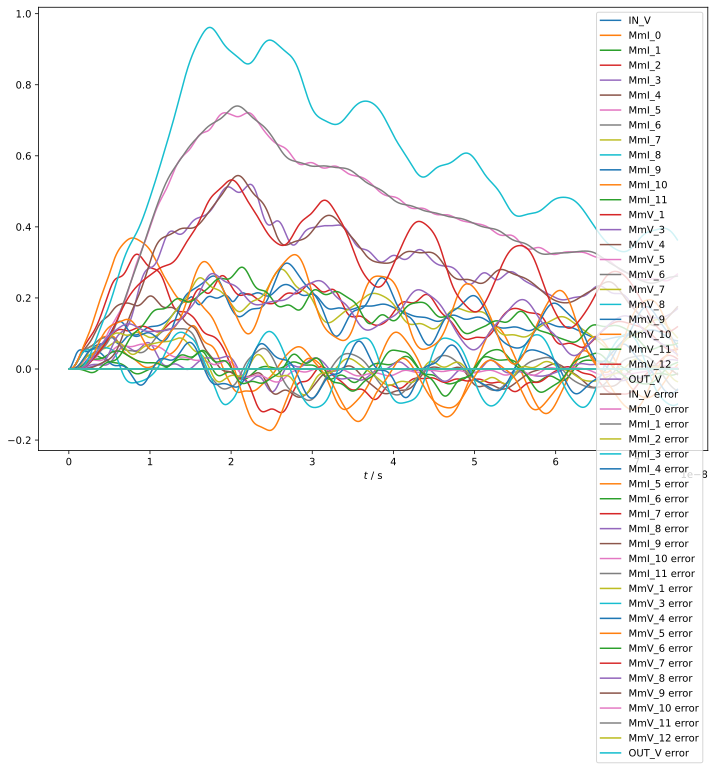

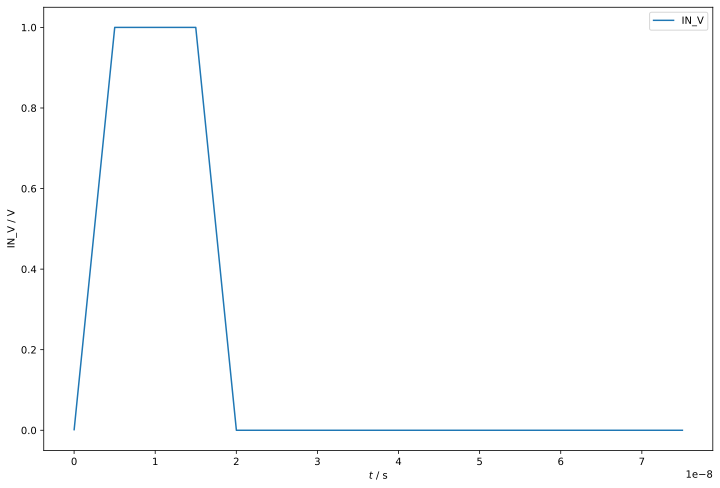

[[5.61080610e-06 1.40358961e-08 3.94998007e-14 ... 7.47173490e-12
  7.52819492e-12 7.52812474e-12]
 [2.23854046e-05 1.12070569e-07 1.26239776e-12 ... 1.48863835e-11
  1.51130561e-11 1.51124958e-11]
 [5.02347403e-05 3.77494529e-07 9.57375767e-12 ... 2.22431212e-11
  2.27549912e-11 2.27531036e-11]
 ...
 [           inf            inf            inf ...            inf
             inf            inf]
 [           inf            inf            inf ...            inf
             inf            inf]
 [           inf            inf            inf ...            inf
             inf            inf]]


Array(9987, dtype=int64, weak_type=True)

In [38]:
end_step = solution.stats['num_steps']
plt.plot(solution.ts[:], solution.ys[:, :])
plt.legend([s.name for s in ds.transient_symbols()] + [s.name + ' error' for s in ds.transient_symbols()])
plt.xlabel('$t$ / s')
plt.gcf().set_size_inches(12, 8)
plt.savefig('full_solution.png', dpi=300)
# plt.ylim(-0.2, 1)
plt.show()
plt.plot(solution.ts, sp.lambdify(sp.symbols('t'), pulse_sympy(sp.symbols('t')))(solution.ts))
plt.legend(['IN_V'], loc='upper right')
plt.xlabel('$t$ / s')
plt.ylabel('IN_V / V')
plt.gcf().set_size_inches(12, 8)
plt.savefig('forcing_function.png', dpi=300)
plt.show()
print(solution.ys)
end_step

In [39]:
solution.ys[end_step - 1]

Array([ 7.92850019e-02,  1.18527098e-02, -1.23956603e-02,  2.82989379e-02,
        2.40117943e-02, -1.55585857e-02,  4.24393544e-03, -6.10495435e-02,
       -3.56045582e-02, -9.87020202e-02, -5.73987949e-02,  5.92874441e-02,
        1.82440682e-02,  5.49407660e-02,  1.69253085e-01,  1.74840647e-01,
        2.67144004e-01,  2.61455369e-01,  8.80499766e-02,  3.63306865e-01,
        6.22120684e-02,  3.73057131e-02,  7.24396925e-02,  1.18658416e-01,
        4.10248246e-02,  1.69820918e-08, -3.13263173e-09, -1.04781703e-09,
       -3.16612961e-09, -1.32348223e-09, -1.15046690e-09, -6.17178621e-10,
       -1.14588368e-09, -5.80452119e-11, -2.58666487e-09, -1.19850014e-09,
       -4.75379220e-09, -8.97656665e-10,  1.73617092e-08,  3.69043516e-08,
        3.79987867e-08,  5.48520438e-08,  5.56553520e-08,  1.79425570e-08,
        7.35969396e-08,  1.75657866e-08,  1.86762769e-08,  1.83536847e-08,
        3.64083238e-08,  1.81871932e-08], dtype=float64, weak_type=True)

In [ ]:
from functools import partial
# Show gradients of the solution graph with respect to a single parameter
n_ts = 1000
ts_space = jnp.linspace(0, 75e-9, 1000)
@eqx.filter_jit
def model_all_ts(parameters: dict) -> jax.Array:
    solution = solve_system(initial_values=keys_to_str(lhs_init_dict), parameter_values=parameters, saveat=dr.SaveAt(ts=ts_space))
    return solution.ys[:, -2:]

@eqx.filter_jit
def regularization_loss(parameters, ts, ys, ds: DynamicalSystem) -> jax.Array:
    """
    Aggregate gradients with respect to transient values y
    Automatically masks for nans and infs.
    """
    gradf_y = partial(jax.grad(ds.f, argnums=1), args=parameters)
    tys = jnp.stack((ts[:, None], ys), axis=0)
    def reduce_fun(current_loss: float, ty_value: jax.Array) -> float:
        new_loss = current_loss + jnp.linalg.norm(gradf_y(ty_value[0], ty_value[1:]), ord=2)
        return new_loss
    return jax.lax.reduce(tys, 0.0)

@eqx.filter_jit
def chaos_loss(ds: DynamicalSystem) -> float:
    

initial_parameters = {k: jnp.array(v) for k, v in keys_to_str(param_dict).items()}
model_grad_fn = jax.jit(jax.jacfwd(model_all_ts))
model_grad = model_grad_fn(initial_parameters)
model_vals = model_all_ts(initial_parameters)
model_grad

In [ ]:
from optax import adam, OptState, apply_updates
print(model_grad.keys())
print(model_vals.shape)
current_parameters = initial_parameters.copy()
start_value = current_parameters['MmE_26_ws']
print(start_value)
t_indices = [200, 400, 600]
goal_values = [0.6, 0.1, 0.2]

def loss(parameters):
    model_vals = model_all_ts(parameters)
    return sum((model_vals[t, -1] - goal_values[i])**2 for i, t in enumerate(t_indices))

loss_grad = jax.jit(jax.grad(loss))
optimizer = adam(learning_rate=2e-11)


@jax.jit
def step_parameters(current_parameters, optimizer_state):
    grads = loss_grad(current_parameters)
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    new_parameters = apply_updates(current_parameters, updates)
    new_parameters = {k: jnp.clip(v, 1e-10, 1e-8) if k.endswith('_l') or k.endswith('_c') else jnp.clip(v, 0.0, None) for k, v in new_parameters.items()}
    return new_parameters, optimizer_state


In [ ]:
optimizer_state = optimizer.init(current_parameters)
for step in trange(50):
    # model_vals = model_all_ts(current_parameters)
    # model_grad = model_grad_fn(current_parameters)

    model_vals = model_all_ts(current_parameters)
    plt.plot(ts_space, model_vals[:, -1])
    plt.scatter([ts_space[t] for t in t_indices], goal_values)
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel('$t$ / s')
    plt.ylabel('OUT_V / V')
    plt.ylim(-0.1, 0.7)
    plt.savefig(f'step_{step}.png', dpi=300)
    plt.show()
    
    # plt.plot(ts_space, model_grad['MmE_26_ws'][:, -1])
    # Plot goal points
    # for i, (t, v, g) in enumerate(zip(ts_space, model_vals[:, -1], model_grad['MmE_26_ws'][:, -1])):
    #     if i % 10 == 0:
    #         plt.arrow(t, v, 0, g * 0.05, width=2e-10, head_length=0.02, lw=0)
    current_parameters, optimizer_state = step_parameters(current_parameters, optimizer_state)
    # print(current_parameters)


In [ ]:
def model_function(parameters: dict) -> jax.Array:
    """Produce the signal output of the model given a set of parameters."""
    solution = solve_system(initial_values=keys_to_str(lhs_init_dict), parameter_values=parameters, saveat=dr.SaveAt(ts=[3e-8,]))
    # Fetch the first timestep, and the first simulation variable (IN_V)
    return solution.ys[0][0]

initial_parameters = {k: jnp.array(v) for k, v in keys_to_str(param_dict).items()}
display(model_function(parameters=initial_parameters))
display(initial_parameters)

In [ ]:
model_grad = eqx.filter_jit(eqx.filter_grad(model_function))

@eqx.filter_jit
def loss_function(parameters: dict) -> jax.Array:
    """Gradients of the model function with respect to each parameter."""
    gradients = model_grad(parameters)
    return jnp.array(sum(gradients[key]**2 for key in gradients))

display(model_grad(initial_parameters))
loss_function(initial_parameters)

In [ ]:
from optax import adam, OptState, apply_updates

optimizer = adam(learning_rate=3e-4)
optimizer_state = optimizer.init(initial_parameters)

initial_parameters = {k: jnp.array(v) for k, v in keys_to_str(param_dict).items()}
@eqx.filter_jit
def step_single(parameters: dict, optimizer_state: OptState) -> tuple[jax.Array, dict, OptState]:
    loss_value, loss_gradients = eqx.filter_value_and_grad(loss_function)(parameters)
    updates, new_optimizer_state = optimizer.update(loss_gradients, optimizer_state)
    new_parameters = apply_updates(parameters, updates)
    return loss_value, new_parameters, new_optimizer_state

for i in range(100):
    loss_value, initial_parameters, optimizer_state = step_single(initial_parameters, optimizer_state)
    print(f'Loss at step {i}: {loss_value}')
    